# Importing packages

In [42]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA, KernelPCA, FastICA, TruncatedSVD
from sklearn.manifold import Isomap, TSNE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from factor_analyzer import FactorAnalyzer

import umap

# Loading data

In [2]:
train_df = pd.read_csv('loan-train.csv')
train_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
test_df = pd.read_csv('loan-test.csv')
test_df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


# EDA

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


# Dimensionality Reduction

## Columns with missing values

Finding columns with missing values greater than a specified threshold

In [5]:
missing_value_pct = train_df.isnull().sum() / train_df.shape[0]

col_names = [col for col in train_df.columns if col!="Loan_Status"]

elimination_candidates = []

for i in range(len(col_names)):
    if missing_value_pct[i] > 0.03:
        elimination_candidates.append(col_names[i])

print(elimination_candidates)

['Self_Employed', 'LoanAmount', 'Credit_History']


C:\Users\vchar\AppData\Local\Temp\ipykernel_2872\238614645.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if missing_value_pct[i] > 0.03:


Showing some columns' distribution

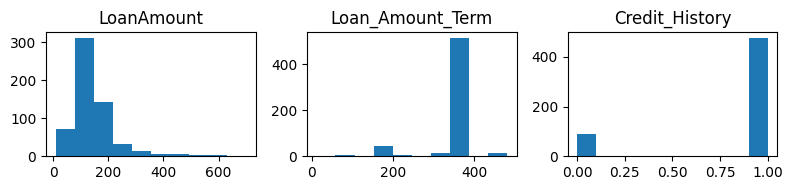

In [6]:
subplot_idx = 1

fig = plt.figure(figsize=(8, 2))

for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']:

    plt.subplot(1, 3, subplot_idx)

    plt.hist(train_df[col])

    plt.title(col)

    subplot_idx += 1

plt.tight_layout()

Filling missing values of the columns shown in the plots above

In [7]:
for col in ['LoanAmount', 'Loan_Amount_Term', 'Credit_History']:
    if col == 'LoanAmount':
        train_df[col].fillna(train_df[col].median(), inplace=True)
    else:
        train_df[col].fillna(train_df[col].mode()[0], inplace=True)

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


## Filtering based on variance

Replacing missing values

In [9]:
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
    train_df[col].fillna(train_df[col].mode()[0], inplace=True)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Applying label encoding

In [10]:
# Removing loan id from the column names
col_names.remove('Loan_ID')

cat_feats = list(train_df[col_names].select_dtypes(include='object').columns)

le_dict = {}

for col in cat_feats:

    le = LabelEncoder()

    train_df[col] = le.fit_transform(train_df[col])

    temp_cat_list = list(le.classes_)

    le_dict[col] = {temp_cat_list[i]: i for i in range(len(temp_cat_list))}

le_dict

{'Gender': {'Female': 0, 'Male': 1},
 'Married': {'No': 0, 'Yes': 1},
 'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3},
 'Education': {'Graduate': 0, 'Not Graduate': 1},
 'Self_Employed': {'No': 0, 'Yes': 1},
 'Property_Area': {'Rural': 0, 'Semiurban': 1, 'Urban': 2}}

Finding elimination candidates based on a variance threshold

In [11]:
VAR_THRESHOLD = 10

var_values = train_df[col_names].var()

var_elim_cols = []

for col in col_names:
    if var_values[col_names.index(col)] < VAR_THRESHOLD:
        var_elim_cols.append(col)

var_elim_cols

C:\Users\vchar\AppData\Local\Temp\ipykernel_2872\2932772723.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if var_values[col_names.index(col)] < VAR_THRESHOLD:


['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area']

## Filtering highly correlated columns

Creating correlation heatmap

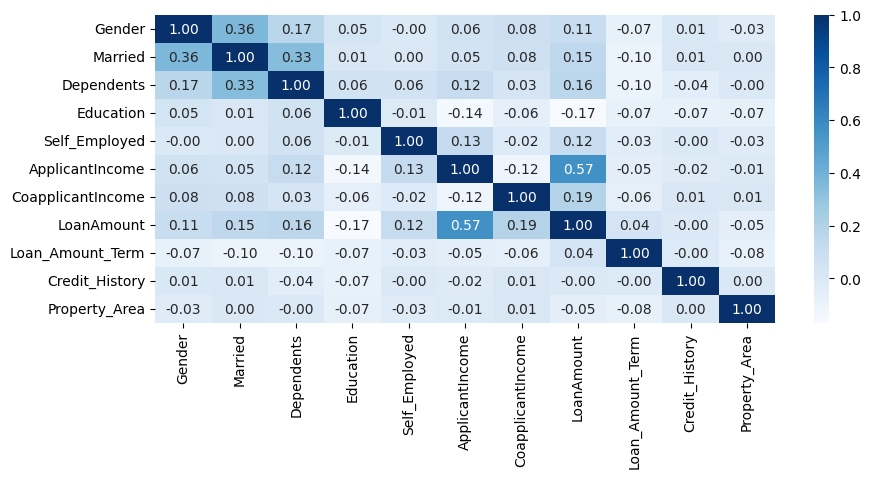

In [12]:
corr_mat = train_df[col_names].corr()

fig = plt.figure(figsize=(10, 4))
sns.heatmap(corr_mat, annot=True, cmap='Blues', fmt='.2f');

Finding features with high correlation

In [13]:
corr_idxs = np.tril_indices_from(corr_mat)

for coord in zip(*corr_idxs):
    corr_mat.iloc[coord[0], coord[1]] = np.nan

corr_df = corr_mat.stack().to_frame().reset_index()
corr_df.columns = ['feature1', 'feature2', 'corr']
corr_df['abs_corr'] = corr_df['corr'].abs()
corr_df.head()

,feature1,feature2,corr,abs_corr
0,Gender,Married,0.364569,0.364569
1,Gender,Dependents,0.172914,0.172914
2,Gender,Education,0.045364,0.045364
3,Gender,Self_Employed,-0.000525,0.000525
4,Gender,ApplicantIncome,0.058809,0.058809


In [14]:
CORR_THRESHOLD = 0.5

corr_df[corr_df['abs_corr'] > CORR_THRESHOLD]

,feature1,feature2,corr,abs_corr
41,ApplicantIncome,LoanAmount,0.565181,0.565181


## Random Forest

Label encoding the target 

In [15]:
target_values = sorted(list(train_df['Loan_Status'].unique()))
print(f"Target unique values: {target_values}")

le_dict['Loan_Status'] = {target_values[i]: i for i in range(len(target_values))}
le_dict

Target unique values: ['N', 'Y']


{'Gender': {'Female': 0, 'Male': 1},
 'Married': {'No': 0, 'Yes': 1},
 'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3},
 'Education': {'Graduate': 0, 'Not Graduate': 1},
 'Self_Employed': {'No': 0, 'Yes': 1},
 'Property_Area': {'Rural': 0, 'Semiurban': 1, 'Urban': 2},
 'Loan_Status': {'N': 0, 'Y': 1}}

Fitting random forest classifier

In [16]:
rf_clf = RandomForestClassifier()

X = train_df[col_names]
y = train_df['Loan_Status'].map(le_dict['Loan_Status'])

rf_clf.fit(X, y)

RandomForestClassifier()

Showing features' importances

In [17]:
rf_feats_imp = rf_clf.feature_importances_
rf_feats_dict = {'feature': col_names, 'importance': rf_feats_imp}
rf_feats_df = pd.DataFrame(rf_feats_dict)
rf_feats_df.sort_values('importance', ascending=False, inplace=True)
rf_feats_df

,feature,importance
9,Credit_History,0.272703
5,ApplicantIncome,0.203324
7,LoanAmount,0.183851
6,CoapplicantIncome,0.118029
2,Dependents,0.047316
10,Property_Area,0.046879
8,Loan_Amount_Term,0.043390
1,Married,0.024715
3,Education,0.022876
0,Gender,0.019301


## Backward elimination

Applying RFE using logistic regression

In [18]:
lr_clf = LogisticRegression(max_iter=150)

rfe_selector = RFE(lr_clf, n_features_to_select=4, step=1)

rfe_selector.fit(X, y)

selected_feats = list(X.columns[rfe_selector.support_])

selected_feats

c:\Users\vchar\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\vchar\anaconda3\envs\ds\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

['Gender', 'Married', 'Education', 'Credit_History']

Applying RFE using random forest

In [19]:
rf_clf = RandomForestClassifier()

rfe_selector = RFE(rf_clf, n_features_to_select=4, step=1)

rfe_selector.fit(X, y)

selected_feats = list(X.columns[rfe_selector.support_])

selected_feats

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Credit_History']

Showing ranking of the features from the last RFE

In [20]:
rfe_selector.ranking_

array([8, 5, 2, 6, 7, 1, 1, 1, 4, 1, 3])

## Forward feature selection

Running SelectKBest

In [21]:
ffs = SelectKBest(f_classif, k=7).fit(X, y)
ffs.pvalues_
ffs.scores_

array([1.98058690e-01, 5.16455172e+00, 6.26648861e-02, 4.54768458e+00,
       8.38037720e-03, 1.35742185e-02, 2.15145736e+00, 6.75896114e-01,
       3.11334050e-01, 2.52652090e+02, 6.31733319e-01])

Showing features' scores

In [22]:
scores = -np.log10(ffs.pvalues_)
scores

array([1.82798507e-01, 1.63081453e+00, 9.56001423e-02, 1.47676514e+00,
       3.28781111e-02, 4.22549231e-02, 8.44821045e-01, 3.85816314e-01,
       2.38773942e-01, 4.71536826e+01, 3.69543291e-01])

In [23]:
skb_dict = {'feature': col_names, 'importance': scores}
skb_df = pd.DataFrame(skb_dict)
skb_df.sort_values('importance', ascending=False, inplace=True)
skb_df

,feature,importance
9,Credit_History,47.153683
1,Married,1.630815
3,Education,1.476765
6,CoapplicantIncome,0.844821
7,LoanAmount,0.385816
10,Property_Area,0.369543
8,Loan_Amount_Term,0.238774
0,Gender,0.182799
2,Dependents,0.095600
5,ApplicantIncome,0.042255


## Factor analysis

Applying factor analysis

In [24]:
fa = FactorAnalyzer(rotation=None, impute='drop', n_factors=len(col_names))
fa.fit(X, y)

FactorAnalyzer(impute='drop', n_factors=11, rotation=None, rotation_kwargs={})

Obtaining eigen values

In [25]:
ev, _ = fa.get_eigenvalues()

Showing eigen values

In [26]:
fa_dict = {'feature': col_names, 'eigen value': ev}
fa_df = pd.DataFrame(fa_dict)
fa_df.sort_values('eigen value', ascending=False, inplace=True)
fa_df

,feature,eigen value
0,Gender,1.913376
1,Married,1.470732
2,Dependents,1.142850
3,Education,1.067521
4,Self_Employed,1.002732
5,ApplicantIncome,0.987282
6,CoapplicantIncome,0.891351
7,LoanAmount,0.805587
8,Loan_Amount_Term,0.794049
9,Credit_History,0.577573


## PCA

Applying PCA

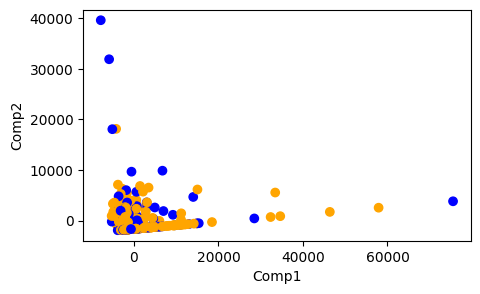

In [27]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

In [28]:
pca.explained_variance_ratio_

array([0.81649994, 0.18331542])

Applying PCA kernel

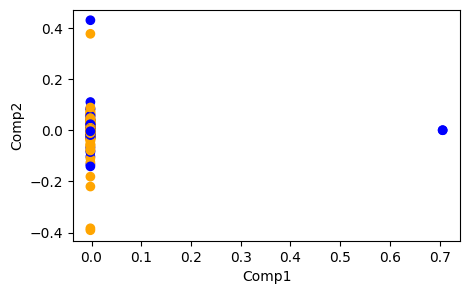

In [29]:
kernel_pca = KernelPCA(n_components=2, kernel='rbf', gamma=15, random_state=42)

X_kernel_pca = kernel_pca.fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_kernel_pca[:, 0], X_kernel_pca[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

## Independent component analysis (ICA)

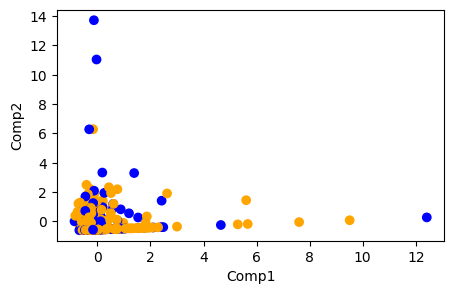

In [30]:
ica = FastICA(
    n_components=2,
    max_iter=500,
    random_state=42
)

X_ica = ica.fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_ica[:, 0], X_ica[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

## Isometric mapping

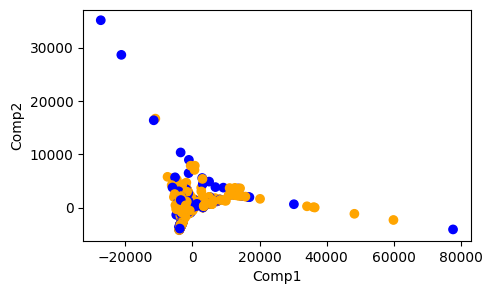

In [31]:
isomap = Isomap(n_components=2, n_neighbors=5, eigen_solver='auto')

X_isomap = isomap.fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

## TSNE

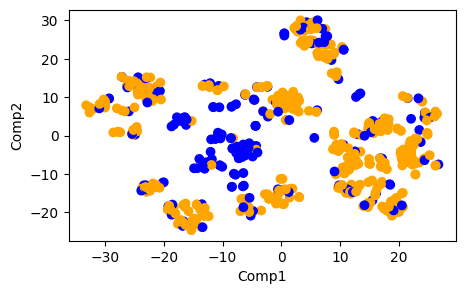

In [32]:
sc = StandardScaler()
pca = PCA()
tsne = TSNE()

tsne_after_pca = Pipeline(
    [
        ('standard scaler', sc),
        ('pca', pca),
        ('tsne', tsne)
    ]
)

X_tsne_after_pca = tsne_after_pca.fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_tsne_after_pca[:, 0], X_tsne_after_pca[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

## Uniform Manifold Approximation and Projection (UMAP)

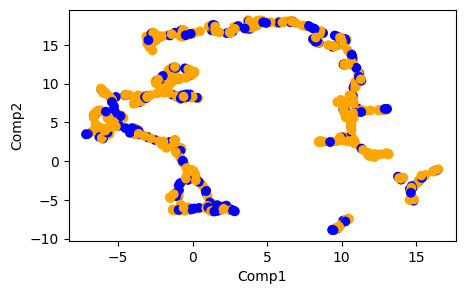

In [40]:
X_umap = umap.UMAP(
    n_neighbors=5,
    min_dist=0.3,
    metric='correlation'
).fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()

## SVD

Finding number components for SVD

In [43]:
def get_models():
    models = dict()
    for i in range(1,11):
        steps = [
            ('svd', TruncatedSVD(n_components=i)),
            ('m', LogisticRegression())
        ]
        models[str(i)] = Pipeline(steps=steps)
    return models

def evaluate_model(model, X, y):

    cv = RepeatedStratifiedKFold(
        n_splits=10,
        n_repeats=3, 
        random_state=1
    )

    scores = cross_val_score(
        model, X, y,
        scoring='accuracy', 
        cv=cv, n_jobs=-1,
        error_score='raise'
    )
    
    return scores

models = get_models()
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>1 0.687 (0.005)
>2 0.688 (0.008)
>3 0.685 (0.010)
>4 0.685 (0.011)
>5 0.685 (0.011)
>6 0.686 (0.010)
>7 0.686 (0.012)
>8 0.681 (0.018)
>9 0.801 (0.032)
>10 0.800 (0.034)


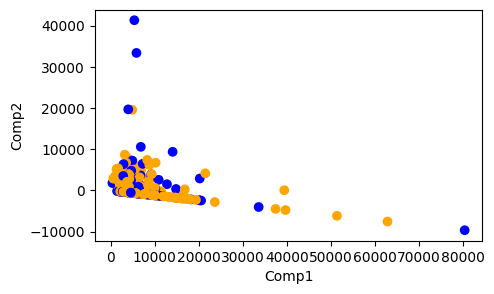

In [46]:
# My initiative: I wanted to check the outcome of the code below

X_svd = TruncatedSVD(n_components=2).fit_transform(X)

fig = plt.figure(figsize=(5, 3))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=train_df['Loan_Status'].map({'Y': 'orange', 'N': 'blue'}))
plt.xlabel('Comp1')
plt.ylabel('Comp2')
plt.show()